<a href="https://colab.research.google.com/github/julx134/Amazon-Recommendation-System-Shilling-Attack-Detector/blob/main/Shilling_Detector_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import os
import csv
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
import sys
from sklearn.metrics import f1_score, roc_curve, auc

# Pre-process dataset

In [ ]:
def test_run_model(name, type, testMode, postfix=''):
  test = testMode
  postfix = postfix

  if name == 'ml':
    # for ML dataset
    batch_size = 20
    epochs = 20
    input_dim = 1682
    dataset_name = f'{name}_100k_{type}'

  if name == 'amazon':
    batch_size = 100
    epochs = 7
    dataset_name = f'{name}_50k_{type}'

    if type == 'average' or type == 'random':
      input_dim = 415
    else:
      input_dim = 416

  return input_dim, dataset_name, test, batch_size, epochs, postfix

input_dim, dataset_name, test, batch_size, epochs, postfix = test_run_model('ml','random',True,'v3')

In [ ]:
# path to custom dataset
load = f"/content/dataset/{dataset_name}.csv"
file_path = os.path.expanduser(load)

#convert csv to dictionary
rating_dict = {'user_id':[], 'item_id':[], 'rating':[]}
with open(file_path, 'r') as dataset:
    for line in csv.reader(dataset):
        rating_dict['user_id'].append(line[0])
        rating_dict['item_id'].append(line[2])
        rating_dict['rating'].append(line[4])

#convert dictionary to dataframe
rating_df = pd.DataFrame.from_dict(rating_dict)

#encode labels
user_encoder = preprocessing.LabelEncoder()
user_encoder.fit(rating_df['user_id'])
item_encoder = preprocessing.LabelEncoder()
rating_df['user_id'] = user_encoder.transform(rating_df['user_id'])
rating_df['item_id'] = item_encoder.fit_transform(rating_df['item_id'])

#normalize 'rating' column
scaler = MinMaxScaler()
rating_df['rating'] = scaler.fit_transform(rating_df[['rating']])



In [ ]:
# vectorize user-item matrix on users
rating_pivot = pd.pivot_table(rating_df, values='rating', index=['user_id'],
                    columns=['item_id'])
rating_pivot = rating_pivot.fillna(0)

print(rating_pivot)
# convert pivot table to numpy array
user_vectors = rating_pivot.values
user_vectors = np.expand_dims(user_vectors, 2)

item_id  0     1     2     3     4     5     6     7     8     9     ...  \
user_id                                                              ...   
0        1.00  0.50   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1        0.75  0.00   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2        0.00  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3        0.00  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4        0.00  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1031     0.00  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1032     0.00  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1033     0.00  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1034     0.00  0.25   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1035     0.00  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

item_id  16

In [ ]:

#import labels and pre-process
load = f"/content/dataset/{dataset_name}_labels.csv"
file_path = os.path.expanduser(load)

#convert csv to dictionary
label_dict = {'user_id':[], 'shilling_attack':[]}
with open(file_path, 'r') as dataset:
    for line in csv.reader(dataset):
        label_dict['user_id'].append(line[0])
        label_dict['shilling_attack'].append(line[1])

#convert dictionary to dataframe
label_df = pd.DataFrame.from_dict(label_dict)

#encode user_id -> ascending sort -> drop duplicates -> convert column type
label_df['user_id'] = user_encoder.transform(label_df['user_id'])
label_df = label_df.sort_values(by='user_id', ascending=True, ignore_index=True)
label_df = label_df.drop_duplicates(subset=['user_id'])
label_df['shilling_attack'] = label_df['shilling_attack'].astype(float)
print(label_df, label_df.shape, label_df.info())

#convert to numpy array
labels = label_df['shilling_attack'].values


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 1036
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          1036 non-null   int64  
 1   shilling_attack  1036 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 24.3 KB
      user_id  shilling_attack
0           0              0.0
1           1              0.0
2           2              0.0
3           3              1.0
4           4              1.0
...       ...              ...
1032     1031              1.0
1033     1032              1.0
1034     1033              1.0
1035     1034              1.0
1036     1035              1.0

[1036 rows x 2 columns] (1036, 2) None


In [ ]:
# randomize x and y values to prevent precision and recall issues
perm = np.random.RandomState(seed=0).permutation(user_vectors.shape[0])
user_vectors = user_vectors[perm]
labels = labels[perm]

#split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(user_vectors,labels,test_size = 0.2, random_state = 0)

# Models

In [ ]:
# Each input sequence will be of size (1, x) (height is treated like time).
# Units is number of LSTM cells or unrolled propagation
units = 64
output_size = 1  # labels are from 0 to 1

def build_model_v1():
  model = Sequential()
  model.add(LSTM(64, activation="relu", input_shape=(input_dim, 1), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Dense(output_size, activation='sigmoid'))

  return model


def build_model_v2():
  model = Sequential()
  model.add(LSTM(256, activation="relu", dropout=0.25, recurrent_dropout=0.25, input_shape=(1682, 1)))
  model.add(Dense(1, activation="sigmoid"))

  return model

# apply batch normalization layer to prevent exploding/vanishing gradient problem
def build_model_v3(): 
  model = Sequential()
  model.add(LSTM(64, activation="relu", input_shape=(input_dim, 1), return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(LSTM(32))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(output_size, activation='sigmoid'))

  return model

# apply batch normalization layer to prevent exploding/vanishing gradient problem
def build_model_v4(): 
  model = Sequential()
  model.add(LSTM(64, activation="sigmoid", input_shape=(input_dim, 1), return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(LSTM(32, activation="sigmoid"))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(output_size, activation='sigmoid'))

  return model

# apply batch normalization layer to prevent exploding/vanishing gradient problem
def build_model_v5(): 
  model = Sequential()
  model.add(LSTM(100, activation="sigmoid", recurrent_dropout=0.25, input_shape=(input_dim, 1), return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(LSTM(50, activation="sigmoid"))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(output_size, activation='sigmoid'))

  return model

In [ ]:
#build model
tf.compat.v1.reset_default_graph()

model = build_model_v3()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.01)

#compile model
#avoid exploding/vanishing gradient problem by setting clipoff
optimizer = optimizers.Adam(clipvalue=0.5)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          optimizer=optimizer,
          metrics=['RootMeanSquaredError', 'MeanAbsoluteError'])

# fit model
model.fit(
      x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[callback]
)



Epoch 1/20
42/42 [==============================] - 138s 3s/step - loss: 0.6766 - root_mean_squared_error: 0.4870 - mean_absolute_error: 0.4674 - val_loss: 0.5947 - val_root_mean_squared_error: 0.4485 - val_mean_absolute_error: 0.4459
Epoch 2/20
42/42 [==============================] - 115s 3s/step - loss: 0.5476 - root_mean_squared_error: 0.4236 - mean_absolute_error: 0.4068 - val_loss: 0.5207 - val_root_mean_squared_error: 0.4071 - val_mean_absolute_error: 0.3968
Epoch 3/20
42/42 [==============================] - 114s 3s/step - loss: 0.4618 - root_mean_squared_error: 0.3741 - mean_absolute_error: 0.3493 - val_loss: 0.4645 - val_root_mean_squared_error: 0.3752 - val_mean_absolute_error: 0.3518
Epoch 4/20
42/42 [==============================] - 112s 3s/step - loss: 0.4005 - root_mean_squared_error: 0.3379 - mean_absolute_error: 0.3003 - val_loss: 0.4161 - val_root_mean_squared_error: 0.3489 - val_mean_absolute_error: 0.3021
Epoch 5/20
42/42 [==============================] - 113s 3s/

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1682, 64)          16896     
                                                                 
 batch_normalization (BatchN  (None, 1682, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1682, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

# RMSE and MAE Metrics

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=100)
print('RMSE:',results[1],'\n','MAE:',results[2])

3/3 [==============================] - 1s 240ms/step - loss: 0.3737 - root_mean_squared_error: 0.3303 - mean_absolute_error: 0.1885
RMSE: 0.3302977681159973 
 MAE: 0.1884613037109375


# Binary Classification of Output

In [ ]:
def getBestThreshold(input, actual):
  fpr, tpr, thresholds = roc_curve(actual, input)
  roc_auc = auc(fpr, tpr)

  # Find the best threshold that maximizes the AUC
  best_threshold = thresholds[np.argmax(tpr - fpr)]

  print('Best threshold:', best_threshold)
  return best_threshold

num_rows = y_test.shape[0]
predictions = np.zeros(num_rows)
predictions_temp = model.predict(x_test)
threshold = getBestThreshold(predictions_temp, y_test)
for i in range (int(num_rows)):
  if predictions_temp[i][0] > threshold:
    predictions[i] = 1

7/7 [==============================] - 2s 235ms/step
Best threshold: 0.08161973


# Precision and Recall Metrics

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
#y_pred1 = model.predict(X_test)
#y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print('Precision score:',precision_score(y_test, predictions , average="macro"))
print('Recall score:',recall_score(y_test, predictions , average="macro"))
print('F1-score:',f1_score(y_test, predictions , average="macro"))


Precision score: 0.5550635348479014
Recall score: 0.5906593406593407
F1-score: 0.3331929331929332


# Save model

In [ ]:
model.save(f'/content/models/{dataset_name}_model_{postfix}')

# Testing Section

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(predictions_temp)

# Get cluster labels and centroids
labels_cluster = kmeans.labels_
reversed_labels = np.max(labels_cluster) - labels_cluster
centroids = kmeans.cluster_centers_

print(labels_cluster)
print(centroids)
# Print f1, precision, and recall scores
print('Precision score:',precision_score(y_test, labels_cluster , average="macro"))
print('Recall score:',recall_score(y_test, labels_cluster , average="macro"))
print('F1-score:',f1_score(y_test, labels_cluster , average="macro"))


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[[0.09394755]
 [0.0401917 ]]
Precision score: 0.42896174863387976
Recall score: 0.43131868131868134
F1-score: 0.43013698630136993


In [ ]:
#data_test = {'Pred': labels_cluster, 'Actual': y_test}
#compare_result = pd.DataFrame(data_test)
#print('Predicted', 'Actual')
#print(compare_result.to_numpy())

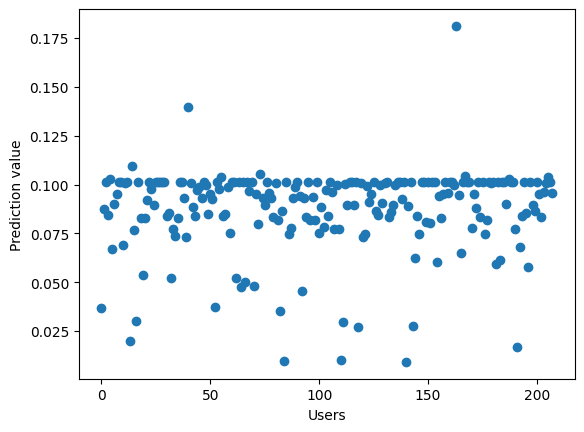

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(range(len(predictions_temp)), predictions_temp)
plt.ylabel('Prediction value')
plt.xlabel('Users')
plt.show()

# Zip and Download Model

In [ ]:
!zip -r /content/ml_100k_models_v3_random20ep.zip /content/models/
from google.colab import files
#files.download(f'/content/{dataset_name}.zip')
files.download(f'/content/ml_100k_models_v3_random20ep.zip')

  adding: content/models/ (stored 0%)
  adding: content/models/ml_100k_random_model_v3/ (stored 0%)
  adding: content/models/ml_100k_random_model_v3/keras_metadata.pb (deflated 91%)
  adding: content/models/ml_100k_random_model_v3/fingerprint.pb (stored 0%)
  adding: content/models/ml_100k_random_model_v3/assets/ (stored 0%)
  adding: content/models/ml_100k_random_model_v3/saved_model.pb (deflated 89%)
  adding: content/models/ml_100k_random_model_v3/variables/ (stored 0%)
  adding: content/models/ml_100k_random_model_v3/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/models/ml_100k_random_model_v3/variables/variables.index (deflated 68%)
  adding: content/models/ml_100k_random_model_v5/ (stored 0%)
  adding: content/models/ml_100k_random_model_v5/keras_metadata.pb (deflated 91%)
  adding: content/models/ml_100k_random_model_v5/fingerprint.pb (stored 0%)
  adding: content/models/ml_100k_random_model_v5/assets/ (stored 0%)
  adding: content/models/ml_100k_random

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>